### Tugas Tunning Hyper Parameter

### Nama : Paul Wijaya Verda Kusuma
### NIM : 215314051
### Mata Kuliah Times Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor

In [2]:
# ==========================================
# 1. Load Dataset hasil preprocessing
# ==========================================
df = pd.read_csv('usd_idr_preprocessed.csv', parse_dates=['Date'], index_col='Date')
# Cek beberapa baris awal
print(df.head())

                   Close
Date                    
2020-01-02  13689.231445
2020-01-03  13884.786133
2020-01-04  13884.786133
2020-01-05  13884.786133
2020-01-06  13934.316406


In [3]:
# Ambil kolom 'Close' dan ubah jadi array 2D
data = df['Close'].values.reshape(-1, 1)

In [4]:
# ==========================================
# 2. Normalisasi agar cocok untuk input LSTM
# ==========================================
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
# ==========================================
# 3. Split data training dan testing
# (misal 30 hari terakhir sebagai testing)
# ==========================================
train_size = len(data_scaled) - 30
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [6]:
# ==========================================
# 4. Fungsi Sliding Window
# Digunakan untuk membuat data time series
# ==========================================
def create_dataset(dataset, window_size=10):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)

# Tentukan panjang window (timesteps)
window_size = 20

X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

In [7]:
# ==========================================
# 5. Ubah bentuk data ke 3D (samples, timesteps, features)
# ==========================================
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
# ==========================================
# 6. Build model function (untuk GridSearch)
# ==========================================
def build_model(units=50):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [9]:
# ==========================================
# 7. Hyperparameter Tuning untuk LSTM menggunakan GridSearchCV
# ==========================================
from scikeras.wrappers import KerasRegressor # Wrapper Scikit-learn untuk model Keras
from sklearn.model_selection import GridSearchCV # Untuk pencarian parameter terbaik

# Inisialisasi KerasRegressor
# - 'build_model' adalah fungsi yang mengembalikan model Keras
# - Parameter seperti 'units', 'optimizer', dsb. harus didefinisikan sebagai default
regressor = KerasRegressor(
    model=build_model,
    units=50,            # default (wajib dideklarasi di sini!)
    optimizer='adam',    # default
    epochs=30,           # default
    batch_size=16,       # default
    verbose=0
)

# Definisikan parameter grid yang akan diuji oleh GridSearch
# Tidak perlu menambahkan prefix 'model__' di scikeras (berbeda dari keras.wrappers)
param_grid = {
    "units": [32, 64, 128],
    "optimizer": ['adam', 'rmsprop'],
    "batch_size": [16, 32],
    "epochs": [30, 50],
}

# Inisialisasi GridSearchCV:
# - estimator: model yang akan dituning
# - param_grid: kombinasi parameter yang akan diuji
# - scoring: metrik evaluasi (negatif MSE karena GridSearchCV ingin *maximize* skor)
# - cv: jumlah fold cross-validation
grid = GridSearchCV(estimator=regressor,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=3)

# Fit ke data pelatihan (proses tuning dimulai)
grid_result = grid.fit(X_train, y_train)

# Tampilkan hasil terbaik
print("Best Params:", grid_result.best_params_)
print("Best Score (neg-MSE):", grid_result.best_score_)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\LENOVO\AppData\Local\Programs\P

Best Params: {'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 32}
Best Score (neg-MSE): -0.0008748083001638109


In [10]:
# ==========================================
# 8. Prediksi & visualisasi hasil LSTM
# ==========================================
best_model = grid_result.best_estimator_

# Prediksi dengan model terbaik
predicted = best_model.predict(X_test)
predicted = predicted.reshape(-1, 1)

# Invers skala untuk interpretasi
predicted_rescaled = scaler.inverse_transform(predicted)
actual_rescaled = scaler.inverse_transform(y_test)


# Invers skala
predicted_rescaled = scaler.inverse_transform(predicted)
actual_rescaled = scaler.inverse_transform(y_test)

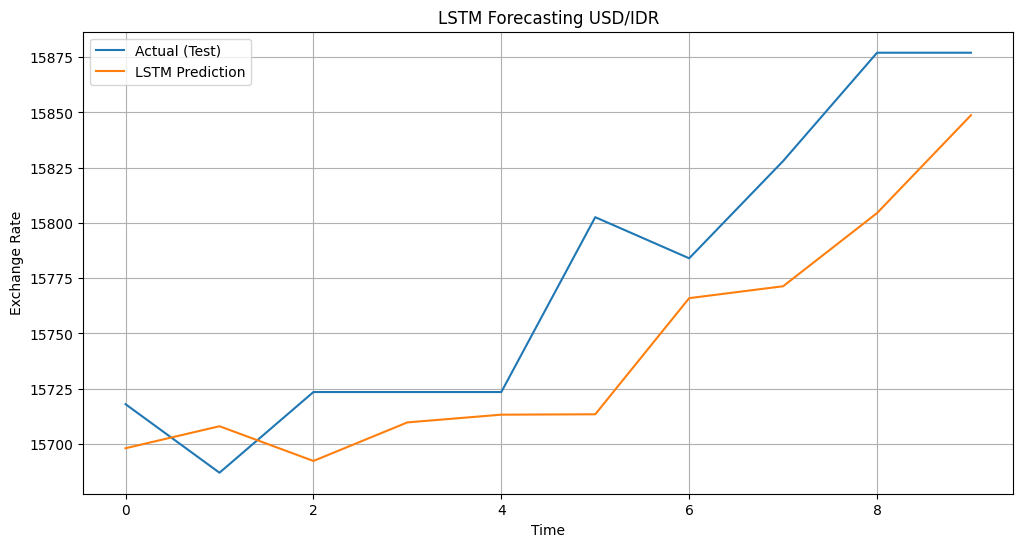

In [11]:
# Plot hasil prediksi vs aktual
plt.figure(figsize=(12, 6))
plt.plot(actual_rescaled, label='Actual (Test)')
plt.plot(predicted_rescaled, label='LSTM Prediction')
plt.title('LSTM Forecasting USD/IDR')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# ==========================================
# 9. Prediksi & visualisasi hasil LSTM
# ==========================================
mse_lstm = mean_squared_error(actual_rescaled, predicted_rescaled)
mae_lstm = mean_absolute_error(actual_rescaled, predicted_rescaled)

print(f"[LSTM] Mean Squared Error: {mse_lstm}")
print(f"[LSTM] Mean Absolute Error: {mae_lstm}")

[LSTM] Mean Squared Error: 1964.7020587921438
[LSTM] Mean Absolute Error: 36.07207031250054


### ANALISA HASIL

GridSearchCV memilih unit = 32 dan optimizer = 'adam' sebagai kombinasi terbaik, dengan jumlah epoch dan batch size yang lebih stabil (50 epoch dan batch 16). 
Skor terbaik (neg_mean_squared_error) menunjukkan bahwa model menunjukkan generalisasi yang baik di data training selama proses cross-validation.

Nilai MSE dan MAE tergolong cukup besar, mengindikasikan bahwa model tidak seakurat yang diharapkan pada data uji (test set).
Ini bisa disebabkan oleh beberapa hal:
- Ukuran data training terlalu kecil (hanya sebagian data digunakan).
- Overfitting ringan karena model dilatih lebih baik di training, tapi tidak generalisasi baik ke testing.
- Distribusi data test berbeda dari training (misalnya tren berubah, ada outlier, atau volatilitas tinggi di 30 hari terakhir).
- Hasil dari GridSearchCV tidak langsung digunakan untuk final training ulang, tapi hanya diuji pada test set 